# Imports

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


# Connect

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Config

In [14]:
class config:
  images_path = '/content/gdrive/MyDrive/licenta/dataset/poze'
  train_file_path = '/content/gdrive/MyDrive/licenta/dataset/train.txt'
  val_file_path = '/content/gdrive/MyDrive/licenta/dataset/validare.txt'
  test_file_path = '/content/gdrive/MyDrive/licenta/dataset/test.txt'
  save_path ='/content/gdrive/MyDrive/licenta/model_vgg16_scratch_improved_v1.pt'
  BATCH_SIZE = 16
  EPOCHS = 50
  LR = [0.001, 0.005, 0.0001, 3e-4]
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
data_dir = config.images_path
num_classes = 7
feature_extract = False

# Model definition

 Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .

In [17]:
class MyVGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(MyVGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.1), # modificat 
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.1), # modificat
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Train Function



In [35]:
map_emotions = {0: "Surprise", 1: "Fear",2: "Disgust",3: "Happiness",4: "Sadness",5: "Anger",6: "Neutral"}

In [ ]:
from numpy import random
def print_image_and_label(item, idx):
  plt.imshow(item[0][idx].permute(1, 2, 0),  interpolation='nearest', aspect='auto')
  plt.title(f'Label:{map_emotions[item[1][idx].item()]}')

def print_image_and_label_for_batch(item):
  plt.figure(figsize = (10,10))

  for idx in range(0,config.BATCH_SIZE):
    plt.subplot(4, 4, idx+1)
    print_image_and_label(item,idx)
  plt.tight_layout()
  plt.show()

In [ ]:
def print_images_during_training(inputs, labels, epoch):
  inputs = inputs.detach().cpu()

  plt.figure(figsize = (14,14))
  for idx in range(0,config.BATCH_SIZE):
    plt.subplot(4, 4, idx+1)
    plt.title(f'[{epoch}]Label:{map_emotions[labels[idx].item()]}')
    plt.imshow(inputs[idx].permute(1, 2, 0),  interpolation='nearest', aspect='auto')

In [ ]:
config.BATCH_SIZE

16

### Train Function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=config.EPOCHS):
    since = time.time()

    val_history = {'val_acc':[], 'val_loss':[]}  
    train_history = {'train_acc':[], 'train_loss':[]}  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        first_inputs = None
        first_labels = None
        step = 0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_losses = [] 
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(config.DEVICE)
                labels = labels.to(config.DEVICE)

                if step==0:
                  first_inputs=inputs
                  first_labels=labels
                step += 1
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                running_losses.append(loss.item()) 
                running_corrects += torch.sum(preds == labels.data)
                
            if phase=='val':
              print('EPOCH:', epoch)
              print_images_during_training(first_inputs,first_labels, epoch)
            if phase=='train':
              scheduler.step()

            epoch_loss = np.mean(running_losses)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print(f'Current Learning Rate Value:{scheduler.get_last_lr()[0]}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), config.save_path)
            if phase == 'val':
                val_history['val_acc'].append(epoch_acc)
                val_history['val_loss'].append(epoch_loss)

            else:
                train_history['train_acc'].append(epoch_acc)
                train_history['train_loss'].append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_history, train_history

In [18]:
def initialize_model( num_classes):
    model = MyVGG16(num_classes).to(config.DEVICE)
    input_size = 224
    return model, input_size

model, input_size = initialize_model( num_classes)


Load Data and transform
---------





https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e

Data transformation performs the transformations on fly in each iteration. So it will not increase the actual scale of our data on  disk

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(input_size),
        transforms.Resize((input_size,input_size)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),  # p is the probability of reflection to occur
        transforms.ToTensor()  # torchvision.transforms.ToTensor()  - It converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]. 
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        # transforms.Normalize([0.5601, 0.4995, 0.4742],[0.3366, 0.3381, 0.3437]),
        # transforms.RandomErasing(p=0.2)  # Unlike other transformations RandomErasing() is applied directly on the tensor; hence it’s after the toTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        # transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        # transforms.Normalize([0.5601, 0.4995, 0.4742],[0.3366, 0.3381, 0.3437])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}
print(f'Image datasets sizes:\nTrain ->',len(image_datasets['train']),'\nValidation: -> ',len(image_datasets['val']) )

Initializing Datasets and Dataloaders...
Image datasets sizes:
Train -> 10335 
Validation: ->  1707


## Test on dummy data

Image dummy datasets sizes:
Train -> 80 
Validation: ->  80


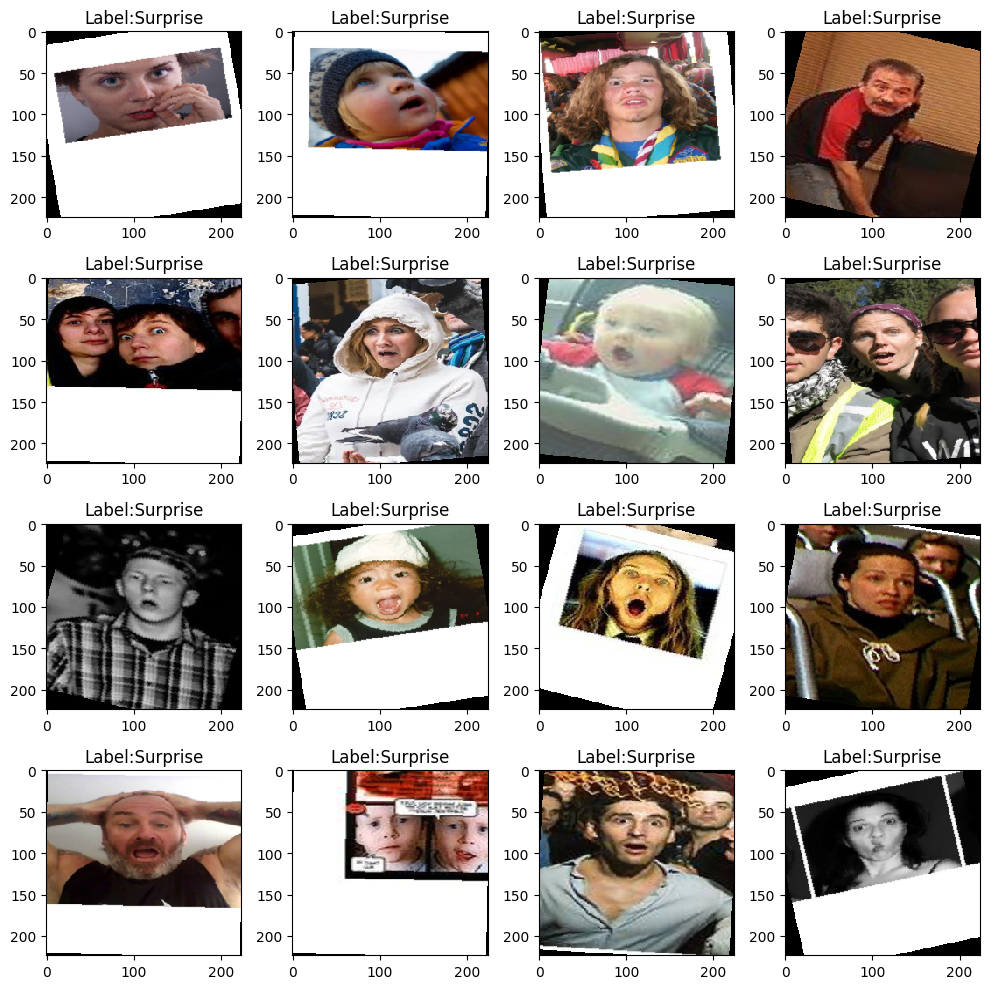

In [ ]:
idxs = list(range(0, 80))
dummy_train_ds=torch.utils.data.Subset(image_datasets['train'],idxs)
dummy_val_ds = torch.utils.data.Subset(image_datasets['val'],idxs)
dummy_ds = {}
dummy_ds['train']=dummy_train_ds
dummy_ds['val']=dummy_val_ds
dummy_dataloaders_dict = {x: torch.utils.data.DataLoader(dummy_ds[x], batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}
print(f'Image dummy datasets sizes:\nTrain ->',len(dummy_ds['train']),'\nValidation: -> ',len(dummy_ds['val']) )
dummy_iterator = iter(dummy_dataloaders_dict['train'])
dummy_item=next(dummy_iterator)
print_image_and_label_for_batch(dummy_item)

In [ ]:
iterator = iter(dataloaders_dict['train'])
item=next(iterator)
len(item), item[1], len(item[0])

(2, tensor([4, 1, 2, 3, 4, 6, 3, 4, 4, 4, 3, 6, 3, 3, 3, 3]), 16)

## Visualize images from train dataset

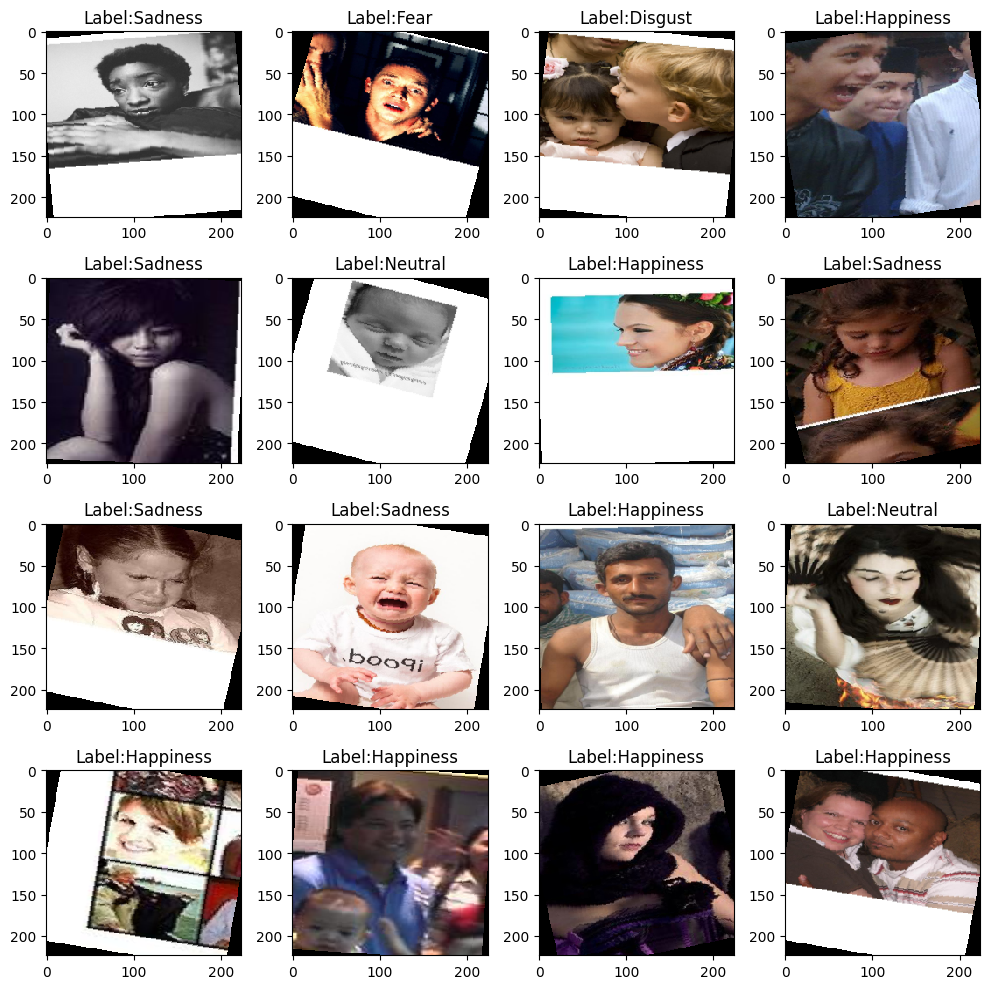

In [ ]:
print_image_and_label_for_batch(item)


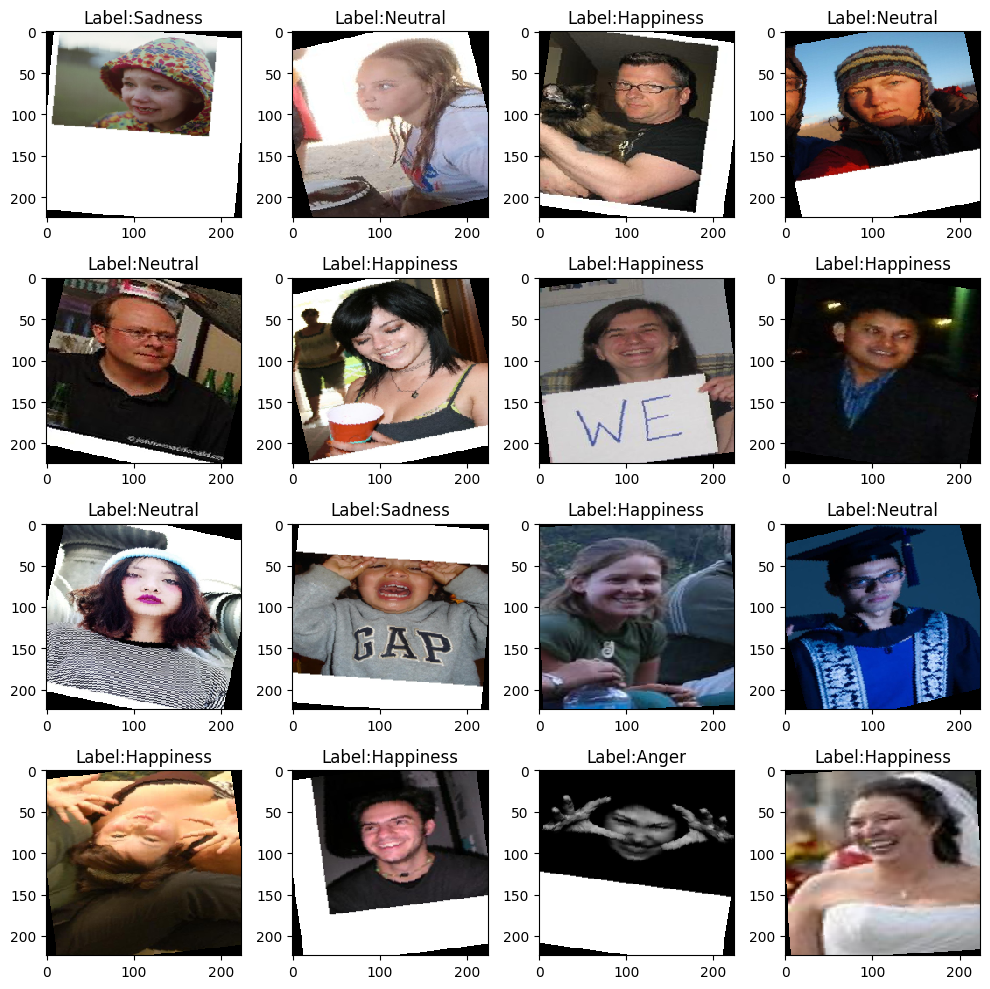

In [ ]:
print_image_and_label_for_batch(next(iterator))

## Visualize images from validation dataset

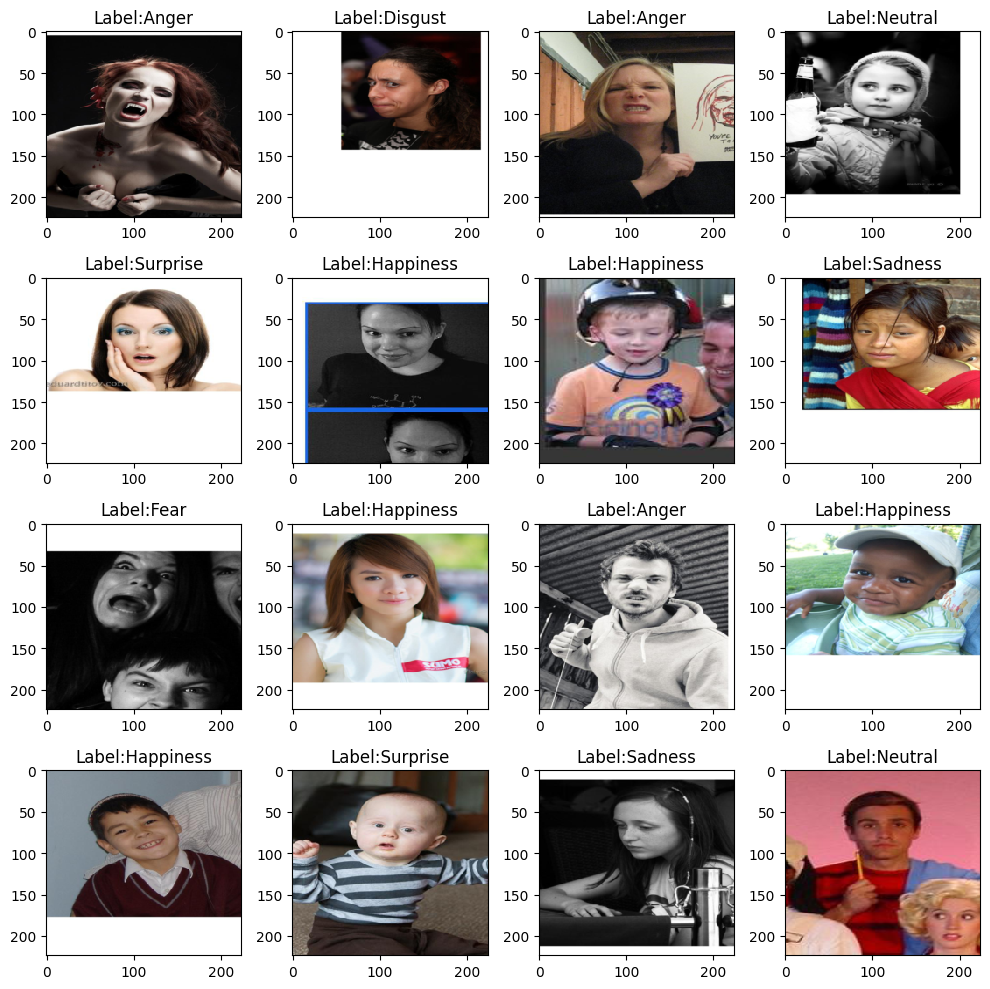

In [ ]:
iterator_val = iter(dataloaders_dict['val'])
item_val=next(iterator_val)
print_image_and_label_for_batch(item_val)

Create the Optimizer
--------------------




In [19]:
model = model.to(config.DEVICE)
params_to_update = model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LR[0], weight_decay = 0.005, momentum = 0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.005
)

Run Training and Validation Step
--------------------------------






In [ ]:
criterion = nn.CrossEntropyLoss()
model,  val_history, train_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config.EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

In [4]:
train_losses = [1.5965,1.5344, 1.3733, 1.2183 , 1.0715, 0.9613 , 0.8842,0.8208 ,0.7678, 0.7252 ,0.5559,0.5070,0.4768 , 0.4476,0.4209,0.3983,0.3799 ,0.3550,0.3344, 0.3179,0.2573,
0.2473,0.2306 ,0.2275 , 0.2254,0.2162,0.2173, 0.2074 ,0.2013,0.2026,0.1927 ,0.1889,0.1843 ,
0.1854,0.1907,0.1802,0.1831, 0.1885, 0.1803 , 0.1839 , 0.1754,0.1844 ,0.1847 ,0.1822 ,0.1829,
0.1859,0.1807,0.1811,0.1778,0.1867]

train_accs = [0.4102, 0.4250, 0.4943, 0.5604, 0.6184, 0.6556, 0.6848, 0.7068,0.7300, 0.7422, 0.8038,0.8209, 0.8343,0.8421,0.8510,0.8634,0.8687,0.8750,0.8818,0.8906,0.9144,0.9178,0.9243,0.9269,0.9269, 0.9316,0.9292, 0.9348,0.9342,0.9350,0.9384,0.9407,0.9427,0.9432, 0.9410,0.9436,0.9414,0.9377,0.9448, 0.9414,0.9458,0.9413, 0.9412,  0.9415,0.9429,0.9406,0.9423,0.9444,0.9444,0.9400]

val_losses = [1.6382, 1.6701, 1.5062, 1.1958, 1.1468, 1.1461 , 1.1810,0.9898 ,0.9768,1.0662,0.7435 ,0.7395 ,0.7415, 0.7409,0.7474 ,0.7891,0.8659,  0.7972,
0.8392 ,0.8629 ,0.7759,0.7873,0.8058,0.7915,0.8248 ,0.8121, 0.8226,0.8304,0.8558 ,0.8407,0.8397,0.8333,0.8347,0.8331,0.8342,0.8403,0.8358,0.8446, 0.8465, 0.8455 ,0.8415,0.8456 ,0.8376, 0.8475,0.8547,0.8486, 0.8467,0.8407,0.8353,0.8391]

val_accs = [0.3591, 0.3158, 0.3749, 0.5536, 0.5565, 0.5753, 0.5981,0.6514,0.6339,0.6426,0.7504,0.7463,0.7487, 0.7475, 0.7633,0.7411,0.7241,0.7411,0.7335,
0.7352,0.7569,0.7563,0.7622, 0.7657, 0.7551,0.7604,0.7551,0.7586,0.7522,0.7575, 0.7592,0.7610,0.7598,0.7610,0.7604, 0.7540, 0.7592,0.7586, 0.7540, 0.7581, 0.7598 ,0.7586,0.7557,0.7581,0.7581,0.7592,0.7569,0.7586, 0.7569, 0.7586]

lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,0.001,0.001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1e-05,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-06,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000002e-07,1.0000000000000004e-08,1.0000000000000004e-08]

# Visualize the performance
------------------------------------------

In [ ]:
def transform_history(instance):
  instance = instance.item()
  return instance
  
val_acc_history = list(map(transform_history, val_history['val_acc']))
train_acc_history = list(map(transform_history, train_history['train_acc']))

In [5]:
def plot_graphs(list1, list2, title,xlabel, ylabel):
  plt.plot(list1)
  plt.plot(list2)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

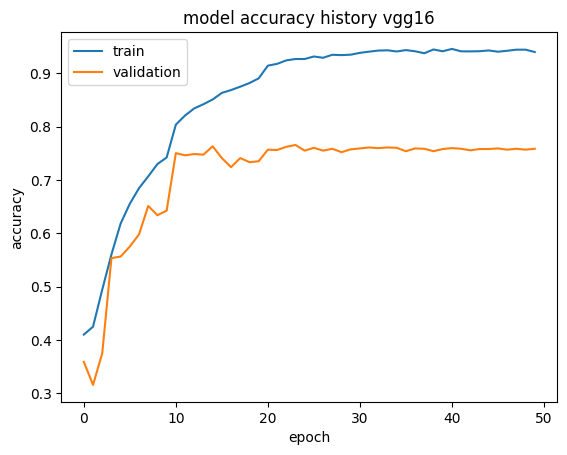

In [ ]:
plot_graphs(train_accs, val_accs, 'model accuracy history vgg16','epoch','accuracy')

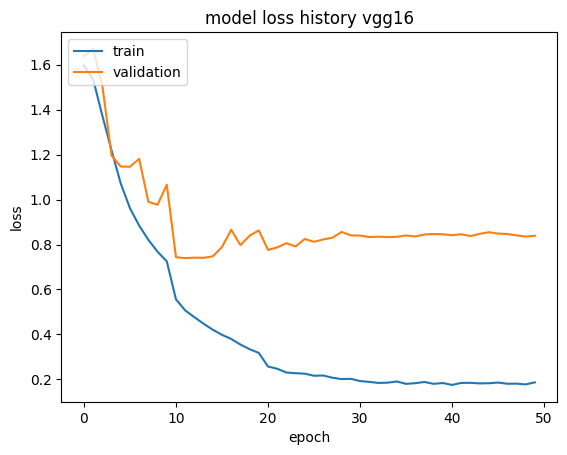

In [ ]:
plot_graphs(train_losses, val_losses, 'model loss history vgg16','epoch','loss')

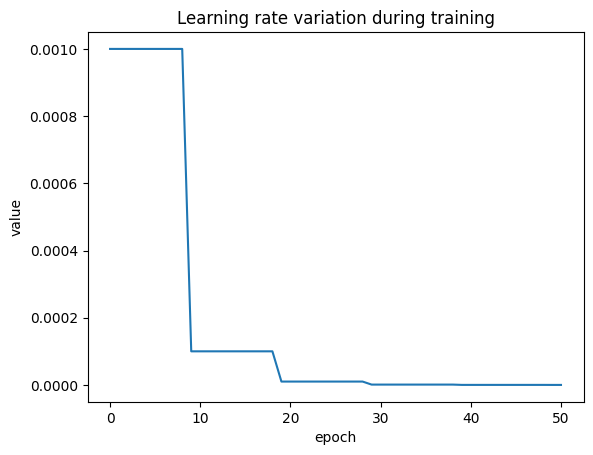

In [7]:
plt.plot(lrs)
plt.title('Learning rate variation during training')
plt.ylabel('value')
plt.xlabel('epoch')
plt.show()

# Test model

In [ ]:
model

MyVGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [20]:
model.load_state_dict(torch.load(config.save_path))

<All keys matched successfully>

In [ ]:
data_transforms_test = {
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

image_test_datasets = datasets.ImageFolder(root = os.path.join(data_dir,'test'),transform=data_transforms_test['test'])
dataloaders_test_dict = torch.utils.data.DataLoader(image_test_datasets, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4) 

Initializing Datasets and Dataloaders...


In [ ]:
dataloaders_test_dict.dataset

Dataset ImageFolder
    Number of datapoints: 3068
    Root location: /content/gdrive/MyDrive/licenta/dataset/poze/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
len(dataloaders_test_dict)*config.BATCH_SIZE

3072

In [ ]:
def test_model(model, dataloader):
    since = time.time()
    model.eval()  

    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Overall Acc: {:4f}'.format(acc))

    return acc

In [ ]:
test_acc = test_model(model,dataloaders_test_dict)

Test complete in 8m 25s
Overall Acc: 0.794003


In [ ]:
test_acc.item()

0.7940026075619295

# Plot Confusion Matrix

In [ ]:
num_classes

7

In [ ]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_test_dict):
        inputs = inputs.to(config.DEVICE)
        classes = classes.to(config.DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 270   11    5   11    7    4   21]
 [  17   36    0    7    6    4    4]
 [   5    3   71   16   25   11   29]
 [   7    7   11 1078   18   10   54]
 [   7    4   10   35  361    5   56]
 [   8    6   19    8    7  105    9]
 [  23    1   29   53   56    3  515]]
[82.0668693  48.64864865 44.375      90.97046414 75.52301255 64.81481481
 75.73529412]


Text(0.5, 80.7222222222222, 'Predicted label')

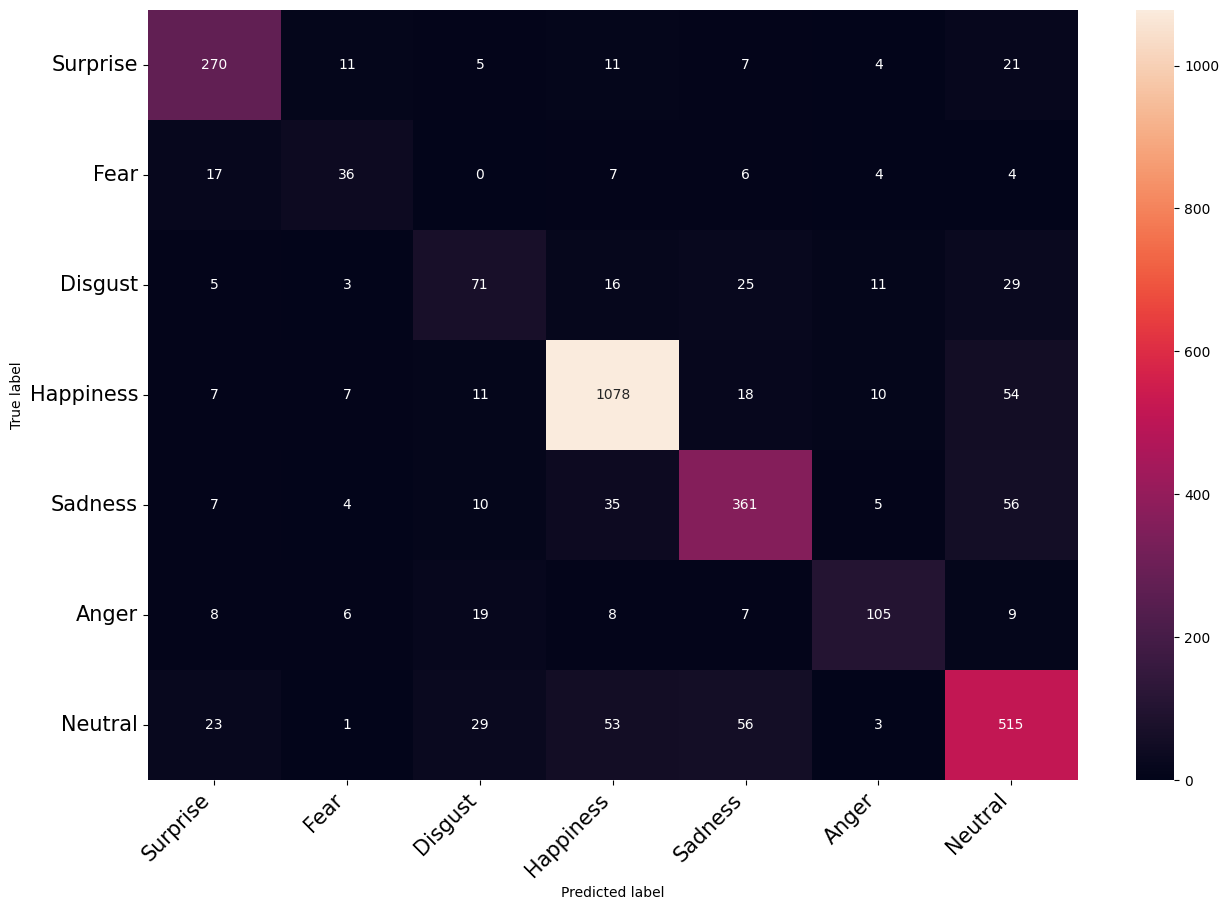

In [ ]:
import pandas as pd
import seaborn as sns

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_test_dict):
        inputs = inputs.to(config.DEVICE)
        classes = classes.to(config.DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = map_emotions.values()

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
print('Class ccuracy:')
for idx, acc in enumerate(class_accuracy):
  print(f'{map_emotions[idx]}: {acc}')

Class ccuracy:
Surprise: 82.06686930091185
Fear: 48.648648648648646
Disgust: 44.375
Happiness: 90.9704641350211
Sadness: 75.52301255230125
Anger: 64.81481481481481
Neutral: 75.73529411764706


# Predict function

In [40]:
import torchvision
from PIL import Image

def predict_label(img_path):
  model.eval()
  input = ''
  img = Image.open(img_path)
  img.show()
  input_size=224
  transform = transforms.Compose([
          transforms.Resize((input_size, input_size)),
          transforms.ToTensor()])
  input = transform(img).unsqueeze(0)
  input = input.to(config.DEVICE)
  
  with torch.set_grad_enabled(False):
    output = model(input)
    _, pred = torch.max(output, 1)
  label = map_emotions[pred.item()]
  print("This is:",label )
  return label

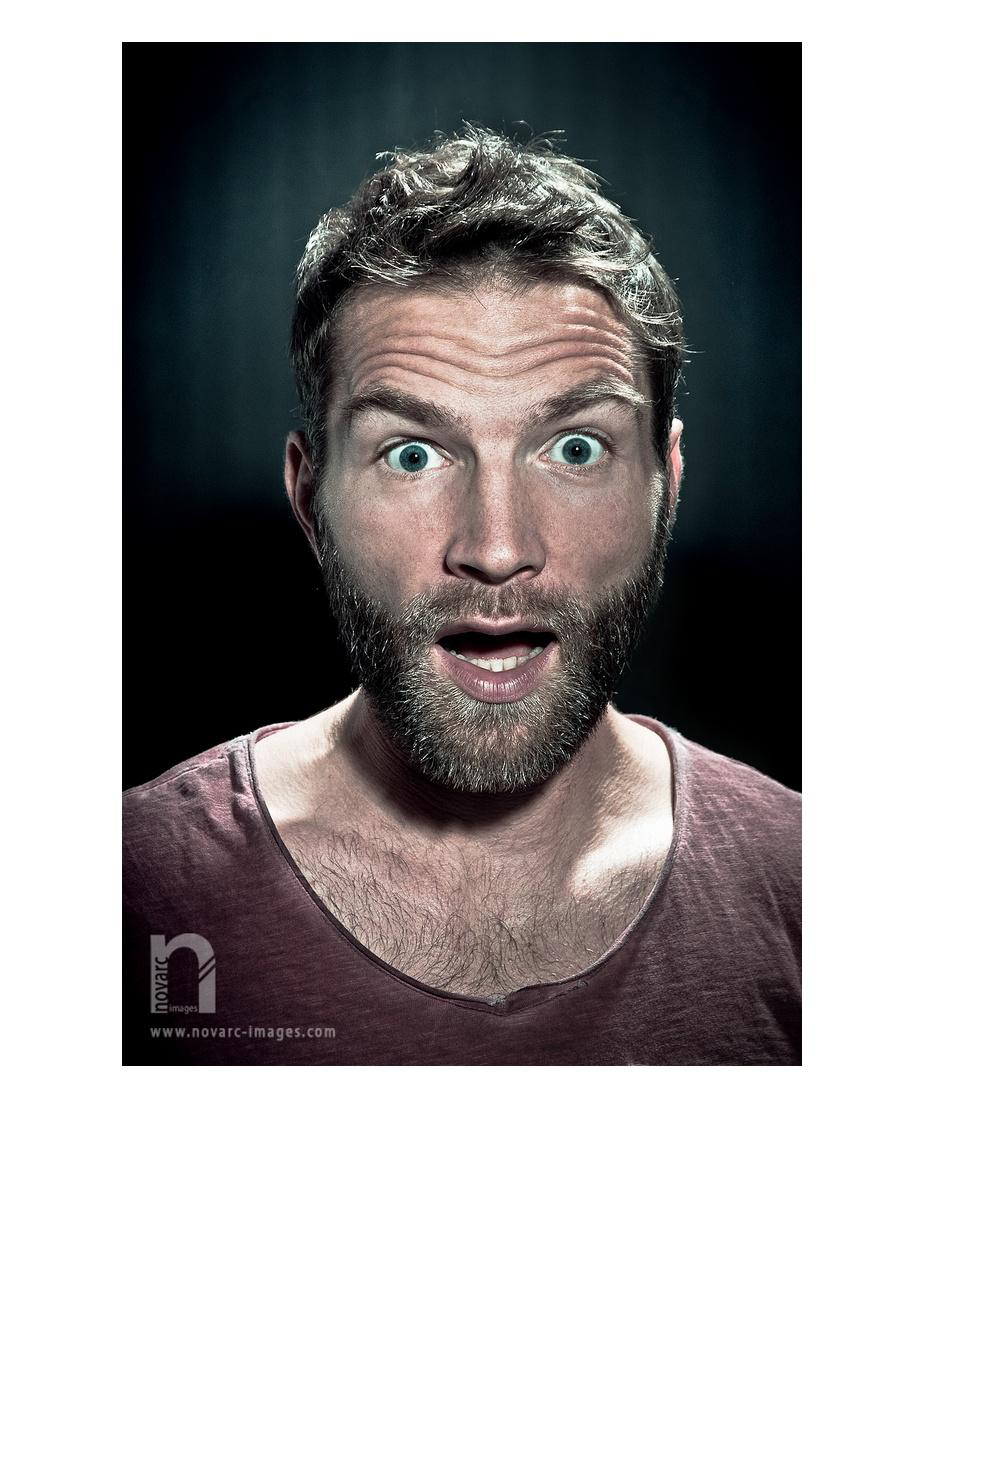

This is: Surprise


'Surprise'

In [42]:
img_path = '/content/gdrive/MyDrive/licenta/test_0094.jpg'
predict_label(img_path)